In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from pathlib import Path
import pandas as pd
import os
import glob
import re
import sys

from ipywidgets import interact, Dropdown

from photutils.aperture import CircularAperture, aperture_photometry
from spectral_cube import SpectralCube

from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from astropy.constants import c
from astropy.io import fits
from astropy.visualization import simple_norm, imshow_norm

import warnings
warnings.filterwarnings('ignore') #TJ ignore warnings (careful enabling this)

home_directory = "/d/ret1/Taylor/jupyter_notebooks/Research" 
parent_dir = Path(home_directory).resolve() #TJ current notebook's parent directory
os.chdir(parent_dir) #TJ change working directory to be the parent directory

from Py_files.Basic_analysis import * #TJ import basic functions from custom package
from Py_files.Convolution_script import * #TJ import convolution functions from custom package

def load_and_sort_convolved_Karin_spectrum(file_path):
    '''import data and sort by wavelength from very particularly structured file
    -------------
    
    Parameters
    -------------
    file_path : type = str - path to file with data
    
    Returns
    -------------
    structured array ('wavelength', 'intensity', 'uncertainty') where intensity and uncertainty are in W/m2/Hz
    '''    
    with open(file_path, 'r') as file:
        header = file.readline().strip().split()
        #TJ check first line structure for compliance
        if ((len(header) == 3) & (type(try_float(header[0])) == type(0.1)) & (type(try_float(header[1])) == type(0.1)) & (type(try_float(header[2])) == type(0.1))):
            data_list = []
            data_list.append((try_float(header[0])*1e-6, try_float(header[1])*1e-20, try_float(header[2])*1e-20))
            aperture_area_sr = (np.pi * (((0.75*u.arcsec).to(u.rad))**2)).value
            for line in file:
                parts = line.strip().split(maxsplit=3)
                
                #TJ Convert numeric columns to floats
                wavelength = float(parts[0])*1e-6 #TJ float required for sorting
                intensity = try_float(parts[1])*1e-20 * aperture_area_sr
                uncertainty = try_float(parts[2])*1e-20 * aperture_area_sr
                
                data_list.append((wavelength, intensity, uncertainty))
        
            #TJ Define dtype with notes as string
            dtype = [
                ('wavelength', float),
                ('intensity', float),
                ('uncertainty', float),
            ]
            
            data = np.array(data_list, dtype=dtype)
            sorted_data = np.sort(data, order=['wavelength'])  #TJ Sort by wavelength
            
            return sorted_data
        else:
            print('''File format is not as expected. Should be 3 columns no header, if not, see "import_data_and_sort_by_wavelength"
            function from Flux_calibration notebook''')
            return None


def extract_filter_name(filename):
    '''extract entire filter name, for example: F164N
    -------------
    
    Parameters
    -------------
    file_name : type = str - name of filter's fits file of format similar to ngc5194_nircam_1v3_f164n_i2d.fits
        *note*: function keys on the "_" and .fits to get filter name, requires lower case filter names, see generalized "sort_filters" function
    
    Returns
    -------------
    filter name as string
    '''   
    # For .fits files: ngc5194_nircam_1v3_f164n_i2d.fits → "f164n"
    if filename.endswith('.fits'):
        parts = os.path.basename(filename).split('_')
        for part in parts:
            if part.startswith('f') and part[1:].replace('n', '').replace('w', '').replace('m', '').isdigit():
                return part.lower()
    # For .dat files: F070M.dat → "f070m"
    elif filename.endswith('.dat'):
        return os.path.splitext(os.path.basename(filename))[0].lower()
    return None


def generate_list_of_files():
    '''cross-matches files in filter_directory to filters with images in image_directory, sorts by filter number
    -------------
    
    Parameters
    -------------
    none 
    
    Returns
    -------------
    list of arrays, first entry is the image file array, second is the filter file array, both sorted by filter numer (in name)
    '''   
    filter_directory = '/d/crow1/tools/cigale/database_builder/filters/jwst/'
    path = ['nircam', 'miri']
    filter_files = np.concatenate([glob.glob(os.path.join(filter_directory + file_path, "*.dat")) for file_path in path])
    image_directory = 'Data_files/Image_files'
    image_files = glob.glob(os.path.join(image_directory, "*.fits"))
    # Initialize aligned lists
    image_file_array = []
    filter_file_array = []
    
    # Loop through .fits files and find matching .dat files
    for fits_file in image_files:
        fits_filter = extract_filter_name(fits_file)
        if not fits_filter:
            continue  # Skip if no filter name found
        
        # Search for matching .dat file
        for dat_file in filter_files:
            dat_filter = extract_filter_name(dat_file)
            if dat_filter == fits_filter:
                image_file_array.append(fits_file)
                filter_file_array.append(dat_file)
                break  # Stop searching after first match
    filter_name_array = [f.split("/")[-1] for f in filter_file_array] #TJ generate array of just the filter names
    filter_numbers = np.array([get_filter_number(file) for file in filter_name_array]) #TJ generate array of just filter numbers
    sort_indices = np.argsort(filter_numbers) #TJ sort by these numbers
    sorted_filter_names = np.array(filter_file_array)[sort_indices]
    sorted_image_files = np.array(image_file_array)[sort_indices]
    return sorted_image_files, sorted_filter_names

def get_filter_number(filter_name):
    '''extracts numbers from filter name (drops F, N, W, etc from the ends)
    -------------
    
    Parameters
    -------------
    filter_files : type = list - list of filter names
    
    Returns
    -------------
    filter name as string
    '''   
    match = re.search(r'[A-Za-z](\d+)[A-Za-z]', filter_name)  # Numbers between ANY letters
    return int(match.group(1)) if match else 0





def get_Fnu_transmission(Fnu_array, wl_array, transmission_array, trans_wl_array):
    '''get expected flux through filter in units of whatever the flux_array is. Make sure to convert to mks units
    -------------
    
    Parameters
    -------------
    Fnu_array : type = array - array of flux density values
    wl_array : type = array - array of wavelength values for the corresponding Fnu_array values (should be in meters)
    transmission_array : type = array - array of unitless transmission coefficient
    trans_wl_array : type = array - array of wavelength values for the corresponding transmission values (should be in meters)

    
    Returns
    -------------
    total_flux : type = float - in units of flux_array
    '''   
    if ((trans_wl_array[0] < wl_array[0]) or (trans_wl_array[-1] > wl_array[-1])): #TJ Check if wavelengths are compatible with filter
        print('wavelengths adjusted to not include full filter')
        idx_start = np.searchsorted(trans_wl_array, wl_array[0], side='left')
        idx_end = np.searchsorted(trans_wl_array, wl_array[-1], side='right')
        
        # Expand by one index if possible
        idx_start = max(0, idx_start - 1)  # Include one lower index
        idx_end = min(len(trans_wl_array), idx_end + 1)  # Include one higher index
        
        # Slice transmission data
        trans_wl_array = trans_wl_array[idx_start:idx_end]
        transmission_array = transmission_array[idx_start:idx_end]
    if len(trans_wl_array) == 0:
        raise ValueError("No overlap between flux wavelengths and filter transmission curve")
    #TJ convert all arrays to numpy arrays for better indexing
    Fnu_array = np.array(Fnu_array)
    wl_array = np.array(wl_array)
    transmission_array = np.array(transmission_array)
    trans_wl_array = np.array(trans_wl_array)

    
    #TJ Convert wavelength to frequency, reverse so freq increases left to right
    spec_freq_array = c / wl_array[::-1]
    Fnu_array = Fnu_array[::-1]
    trans_freq_array = c / trans_wl_array[::-1]
    transmission_array = transmission_array[::-1]

    #TJ Interpolate Fnu onto the transmission frequency grid
    #TJ this is because jwst transmission arrays are averages over BW widths which are much coarser than Fnu is.
    
    interp_Fnu = np.interp(trans_freq_array, spec_freq_array, Fnu_array)
    
    
    weight = transmission_array / trans_freq_array #TJ weight the numerator and denominator by T *d_nu over nu for integration
    numerator = np.trapz(interp_Fnu * weight, trans_freq_array)#TJ perform integration
    denominator = np.trapz(weight, trans_freq_array)
    ab_mean_flux = numerator / denominator
    # Numerator: Fν * Transmission / nu integrated over frequency
    
    return ab_mean_flux.value



def fake_missing_header_info(filepath):
    '''WARNING!!! This will overwrite blank header fields permanently. If you want to retain those empty fields,
        perform this function on a copy of the file
    -------------
    
    Parameters
    -------------
    filepath : type = str - string to location of IFU fits file
    
    Returns
    -------------
    nothing, updates the fits file to have the fields 'DATE-BEG' 'MJD-BEG' 'DATE-END' 'MJD-END' 'XPOSURE' 'TELAPSE'
    '''   
    
    with fits.open(filepath, mode='update') as hdul:
        hdr = hdul['SCI'].header
        
        # Dictionary of default values (key: (value, comment))
        defaults = {
            'DATE-BEG': ('2000-01-01T00:00:00', 'Default observation start date'),
            'MJD-BEG': (51544.0, 'Default MJD observation start'),
            'DATE-END': ('2000-01-01T00:01:00', 'Default observation end date'),
            'MJD-END': (51544.000694, 'Default MJD observation end'),
            'XPOSURE': (60.0, 'Default exposure time [s]'),
            'TELAPSE': (60.0, 'Default elapsed time [s]')
        }
        
        # Only add missing keywords
        for key, (value, comment) in defaults.items():
            if key not in hdr:
                hdr[key] = (value, comment)
                print(f"Added default {key} = {value}")
            else:
                print(f"Preserved existing {key} = {hdr[key]}")
        
        # Special case: If DATE-BEG exists but MJD-BEG doesn't, compute it
        if 'DATE-BEG' in hdr and 'MJD-BEG' not in hdr:
            try:
                t = Time(hdr['DATE-BEG'], format='isot')
                hdr['MJD-BEG'] = (t.mjd, 'Computed from DATE-BEG')
                print(f"Computed MJD-BEG from DATE-BEG: {t.mjd}")
            except ValueError:
                hdr['MJD-BEG'] = (51544.0, 'Fallback MJD value')
        
        # Similar for DATE-END/MJD-END
        if 'DATE-END' in hdr and 'MJD-END' not in hdr:
            try:
                t = Time(hdr['DATE-END'], format='isot')
                hdr['MJD-END'] = (t.mjd, 'Computed from DATE-END')
            except ValueError:
                pass



def get_IFU_spectrum(IFU_filepath, loc, radius):
    '''extract spectrum from IFU file with aperature of radius, centered at ra,dec = loc
    does not replace negative flux values
    -------------
    
    Parameters
    -------------
    IFU_filepath : type = str - string to location of IFU fits file
    loc : type = list - ra, dec in degrees or SkyCoord object
    radius : type = float - radius of aperture, must have units attached (like u.deg or u.arcsecond)
    
    Returns
    -------------
    structured array with entries for "wavelength" and "intensity"
    '''   
    #fake_missing_header_info(IFU_filepath) #TJ run this if needed
    hdul = fits.open(IFU_filepath)
    header = hdul['SCI'].header
    wcs = WCS(header)
    cube = SpectralCube.read(IFU_filepath, hdu='SCI')

    # === CONVERT RA/DEC TO PIXEL COORDINATES ===
    # Create SkyCoord object for spatial coordinates
    if type(loc) == list:
        spatial_coords = SkyCoord(ra=loc[0]*u.deg, dec=loc[1]*u.deg)
    elif type(loc) == SkyCoord:
        spatial_coords = loc
    else:
        print('loc is not a list of ra, dec and it is not a SkyCoord object.')
        return None
    
    # Convert spatial coordinates to pixels
    x, y = wcs.celestial.all_world2pix(spatial_coords.ra.deg, 
                                      spatial_coords.dec.deg, 0)
    
    # === BUILD APERTURE ===
    if header['CDELT2'] != header['CDELT1']:
        print('pixels are not square!  revisit get_IFU_spectrum() function to fix')
        return None
    cdelt = np.abs(header['CDELT2']) * u.deg
    pixel_scale = cdelt.to(u.arcsec)  # arcsec/pixel
    pix_area = header['PIXAR_SR'] #TJ pixel area in steradians
    radius = radius.to(u.arcsec)
    radius_pix = (radius / pixel_scale).value
    aperture = CircularAperture((x, y), r=radius_pix)
    aperture_area_sr = np.pi * (radius.to(u.rad))**2

    # === CRITICAL UNIT HANDLING ===
    cube = cube.with_spectral_unit(u.m)  # Ensure wavelength in meters
    
    # Convert flux units properly
    # Step 1: MJy/sr → W/m²/Hz/sr
    cube = cube.to(u.W/(u.m**2 * u.Hz * u.sr))  
    
    # Step 2: Multiply by pixel area to get W/m²/Hz/pixel
    pix_area_sr = header['PIXAR_SR'] * u.sr
    cube = cube * pix_area_sr
    
    # Step 3: Perform aperture sum (now in W/m²/Hz)
    flux_density_spectrum = []
    for i in range(len(cube.spectral_axis)):
        image_slice = cube[i].value  # Now in W/m²/Hz
        phot = aperture_photometry(image_slice, aperture)
        flux_density_spectrum.append(phot['aperture_sum'][0])  # No extra multiplication!
    wavelengths = cube.spectral_axis.to(u.m).value
    flux_density_spectrum = np.array(flux_density_spectrum)

    dtype = [('wavelength', 'f8'), ('intensity', 'f8')]
    spectrum = np.zeros(len(cube.spectral_axis), dtype=dtype)
    spectrum['wavelength'] = cube.spectral_axis.to(u.m).value
    spectrum['intensity'] = np.array(flux_density_spectrum)

    return spectrum


def get_image_flux(image_file, loc, radius):
    '''extract flux from image file with aperature of radius, centered at ra,dec = loc
    -------------
    
    Parameters
    -------------
    image_file : type = str - string to location of image fits file
    loc : type = list - ra, dec in degrees or SkyCoord object
    radius : type = float - radius of aperture, must have units attached (like u.deg or u.arcsecond)
    
    Returns
    -------------
    flux_density observed through filter
    '''
    #TJ assign location as SkyCoord object
    if type(loc) == list:
        spatial_coords = SkyCoord(ra=loc[0]*u.deg, dec=loc[1]*u.deg)
    elif type(loc) == SkyCoord:
        spatial_coords = loc
    else:
        print('loc is not a list of ra, dec and it is not a SkyCoord object.')
        return None
    hdul = fits.open(image_file) #TJ load file
    data = hdul['SCI'].data*1e-20  #TJ convert flux density to mks units
    header = hdul['SCI'].header #TJ load header
    if header['BUNIT'] != 'MJy/sr': #TJ check if units are MJy/sr, output will be nonsensical if not
        print('flux is NOT in MJy/sr. review get_image_flux function to fix')
        return None
    pix_area = header["PIXAR_SR"] #TJ define the angular size of a pixel in staradians
    wcs = WCS(header) #TJ read in the world coordinate system
    radius_pixels = (radius).to_value(u.deg) / abs(header['CDELT2']) #TJ get the radius of the aperture in number of pixels
    
    #TJ Convert RA/Dec to pixel coordinates
    x, y = wcs.all_world2pix(spatial_coords.ra.deg, spatial_coords.dec.deg, 0)
    aperture = CircularAperture((x, y), r = radius_pixels)
    
    #TJ Perform aperture photometry
    phot_result = aperture_photometry(data, aperture)
    total_flux = phot_result['aperture_sum'][0]*pix_area  #TJ the result is in pixel units, multiply by steradians per pixel to get units right

    return total_flux    

def compare_IFU_to_image(IFU_filepath, image_filepath, filter_filepath, loc, radius):
    '''extract spectrum from IFU file with aperature of radius, centered at ra,dec = loc using filter data (must be in meters)
       extract total flux from image file for circle centered at loc with radius radius
       compare the two.
    -------------
    
    Parameters
    -------------
    IFU_filepath : type = str - string to location of IFU fits file
    image_filepath : type = str - string to location of image fits file
    filter_filepath : type = list - first entry is an array of wavelengths (in m)
    loc : type = list - ra, dec in degrees or SkyCoord object
    radius : type = float - radius of aperture, must have units attached (like u.deg or u.arcsecond)
    
    Returns
    -------------
    IFU predicted flux, image_extracted flux, ratio
    '''   
    IFU_hdul = fits.open(IFU_filepath)
    IFU_data = IFU_hdul['SCI'].data  # flux in MJy/sr or μJy/arcsec²
    IFU_header = IFU_hdul['SCI'].header
    IFU_SED_data = get_IFU_spectrum(IFU_filepath, loc, radius)
    aperture_area_sr = np.pi * (radius.to(u.rad))**2
    filter_data = []
    with open(filter_filepath, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)
            
    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
    filter_trans = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
    
    print('IFU', IFU_SED_data["wavelength"][0], IFU_SED_data["wavelength"][-1])
    print('filter', filter_wl[0], filter_wl[-1])
    
    IFU_expected_flux = ((get_Fnu_transmission(IFU_SED_data["intensity"], IFU_SED_data["wavelength"], filter_trans, filter_wl)))
    photo_flux = (get_image_flux(image_filepath, loc, radius))
    if IFU_expected_flux:
        return IFU_expected_flux, photo_flux, IFU_expected_flux/photo_flux
    else:
        return None
if __name__ == "__main__":
    #########################################################################
    #TJ update values in this region every time!

    include_karin = True
    show_raw_fluxes = True
    show_normalized_fluxes = True
    image_files, filter_files = generate_list_of_files()
    #SED_filepath = 'Data_files/ARM2_HII2_stitch.dat' #TJ switch to this one and rerun to use unconvolved array

    if include_karin:
        SED_filepath = 'Data_files/ARM2_HII2_conv_stitched_test.dat' 
        karin_SED_data = load_and_sort_convolved_Karin_spectrum(SED_filepath) #TJ this is a precomputed spectra to compare to IFU derived data
    #TJ define IFU file path
    IFU_filepath = 'Data_files/IFU_files/M51_SW_f290lp_g395m-f290lp_s3d.fits'
    IFU_hdul = fits.open(IFU_filepath)
    IFU_data = IFU_hdul['SCI'].data  # flux in MJy/sr or μJy/arcsec²
    IFU_header = IFU_hdul['SCI'].header
    
    loc = [202.4340450, 47.1732517] #TJ define location, radius, and aperture area
    radius = 0.75*u.arcsec
##############################################################################
    
    aperture_area_sr = np.pi * (radius.to(u.rad))**2
    
    print("Compressing IFU data cube into 2d array with flux summed over all pixels in aperture")
    IFU_335 = get_IFU_spectrum("Data_files/IFU_files/M51_IFU_convolved_to_F335M.fits", loc, radius)
    IFU_360 = get_IFU_spectrum("Data_files/IFU_files/M51_IFU_convolved_to_F360M.fits", loc, radius)
    IFU_405 = get_IFU_spectrum("Data_files/IFU_files/M51_IFU_convolved_to_F405N.fits", loc, radius)
    IFU_430 = get_IFU_spectrum("Data_files/IFU_files/M51_IFU_convolved_to_F430M.fits", loc, radius)
    IFU_444 = get_IFU_spectrum("Data_files/IFU_files/M51_IFU_convolved_to_F444W.fits", loc, radius)
    IFU_560 = get_IFU_spectrum("Data_files/IFU_files/M51_IFU_convolved_to_F560W.fits", loc, radius)
    IFU_770 = get_IFU_spectrum("Data_files/IFU_files/M51_IFU_convolved_to_F770W.fits", loc, radius)
    IFU_1000 = get_IFU_spectrum("Data_files/IFU_files/M51_IFU_convolved_to_F1000W.fits", loc, radius)
    IFU_1130 = get_IFU_spectrum("Data_files/IFU_files/M51_IFU_convolved_to_F1130W.fits", loc, radius)
    IFU_1280 = get_IFU_spectrum("Data_files/IFU_files/M51_IFU_convolved_to_F1280W.fits", loc, radius)
    IFU_1500 = get_IFU_spectrum("Data_files/IFU_files/M51_IFU_convolved_to_F1500W.fits", loc, radius)
    IFU_1800 = get_IFU_spectrum("Data_files/IFU_files/M51_IFU_convolved_to_F1800W.fits", loc, radius)
    IFU_2100 = get_IFU_spectrum("Data_files/IFU_files/M51_IFU_convolved_to_F2100W.fits", loc, radius)
    IFU_SED_data = get_IFU_spectrum(IFU_filepath, loc, radius)
    
    print("Extracting filter data")
    filter_data_array = [] #TJ initialize filter data array
    
    for file in filter_files: #TJ loop through filter files and extract wl and transmission data
        data = []
        with open(file, 'r') as f:
                header = f.readline().strip().split()
                for line in f:
                    data_line = line.strip().split()
                    data.append(data_line)
                
        header, filter_T = data[:2], np.array(data[2:])

        wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
        T = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
        filter_data_array.append([wl, T])
    #TJ initialize arrays
    if include_karin:
        Karin_expected_flux = []
    IFU_expected_flux = []
    photo_flux = []
    NIRSpec_indices = []
    print('doing the work')
    for i, filter_data in enumerate(filter_data_array):
        if include_karin:
            Karin_expected_flux.append((get_Fnu_transmission(karin_SED_data["intensity"], karin_SED_data["wavelength"], filter_data[1], filter_data[0])))
        IFU_expected = (get_Fnu_transmission(IFU_SED_data["intensity"], IFU_SED_data["wavelength"], filter_data[1], filter_data[0]))

        if IFU_expected:
            IFU_expected_flux.append(IFU_expected)
            NIRSpec_indices.append(i)
        photo_flux.append(get_image_flux(image_files[i], loc, radius))
    IFU_444_expected = (get_Fnu_transmission(IFU_444["intensity"], IFU_444["wavelength"], filter_data_array[15][1], filter_data_array[15][0]))
    IFU_430_expected = (get_Fnu_transmission(IFU_430["intensity"], IFU_430["wavelength"], filter_data_array[14][1], filter_data_array[14][0]))
    IFU_405_expected = (get_Fnu_transmission(IFU_405["intensity"], IFU_405["wavelength"], filter_data_array[13][1], filter_data_array[13][0]))
    IFU_360_expected = (get_Fnu_transmission(IFU_360["intensity"], IFU_360["wavelength"], filter_data_array[12][1], filter_data_array[12][0]))
    IFU_335_expected = (get_Fnu_transmission(IFU_335["intensity"], IFU_335["wavelength"], filter_data_array[11][1], filter_data_array[11][0]))
    '''IFU_560_expected = (get_Fnu_transmission(IFU_560["intensity"], IFU_560["wavelength"], filter_data_array[16][1], filter_data_array[16][0]))
    IFU_770_expected = (get_Fnu_transmission(IFU_770["intensity"], IFU_770["wavelength"], filter_data_array[17][1], filter_data_array[17][0]))
    IFU_1000_expected = (get_Fnu_transmission(IFU_1000["intensity"], IFU_1000["wavelength"], filter_data_array[18][1], filter_data_array[18][0]))
    IFU_1130_expected = (get_Fnu_transmission(IFU_1130["intensity"], IFU_1130["wavelength"], filter_data_array[19][1], filter_data_array[19][0]))
    IFU_1280_expected = (get_Fnu_transmission(IFU_1280["intensity"], IFU_1280["wavelength"], filter_data_array[20][1], filter_data_array[20][0]))
    IFU_1500_expected = (get_Fnu_transmission(IFU_1500["intensity"], IFU_1500["wavelength"], filter_data_array[21][1], filter_data_array[21][0]))
    IFU_1800_expected = (get_Fnu_transmission(IFU_1800["intensity"], IFU_1800["wavelength"], filter_data_array[22][1], filter_data_array[22][0]))
    IFU_2100_expected = (get_Fnu_transmission(IFU_2100["intensity"], IFU_2100["wavelength"], filter_data_array[23][1], filter_data_array[23][0]))'''

    print("work completed")

    #TJ convert to numpy array for better indexing and mathematics
    #Karin_expected_flux = np.array(Karin_expected_flux)
    IFU_expected_flux = np.array(IFU_expected_flux)
    photo_flux = np.array(photo_flux)
    NIRSpec_indices = np.array(NIRSpec_indices)
    
    if show_normalized_fluxes:
        plt.style.use('seaborn-v0_8-paper')  #TJ just a random style for the plot
        
        plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12}) #TJ 
        # Now plot with sorted data
        plt.figure(figsize=(10, 6))
        if include_karin:
            plt.scatter([extract_filter_name(x) for x in filter_files], Karin_expected_flux/photo_flux, label='Karin convolution', s=100, marker='o', color='blue')
        plt.scatter([extract_filter_name(x) for x in filter_files[NIRSpec_indices]], IFU_expected_flux/photo_flux[NIRSpec_indices], label='raw IFU', s=100, marker='x', color='red')
        plt.scatter(extract_filter_name(filter_files[11]), IFU_335_expected/photo_flux[11], label='my convolution', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[12]), IFU_360_expected/photo_flux[12], label='', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[13]), IFU_405_expected/photo_flux[13], label='', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[14]), IFU_430_expected/photo_flux[14], label='', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[15]), IFU_444_expected/photo_flux[15], label='', s=50, marker='x', color='black')
        '''plt.scatter(extract_filter_name(filter_files[16]), IFU_560_expected/photo_flux[16], label='', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[17]), IFU_770_expected/photo_flux[17], label='', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[18]), IFU_1000_expected/photo_flux[18], label='', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[19]), IFU_1130_expected/photo_flux[19], label='', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[20]), IFU_1280_expected/photo_flux[20], label='', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[21]), IFU_1500_expected/photo_flux[21], label='', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[22]), IFU_1800_expected/photo_flux[22], label='', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[23]), IFU_2100_expected/photo_flux[23], label='', s=50, marker='x', color='black')'''

        plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.7)
        plt.xticks(rotation=45, ha='right')
        plt.tick_params(axis='y', which='both', labelsize=10)
        plt.legend()
        plt.xlabel('Filter Names')
        plt.ylabel('Filter Pass Through (MJy)')
        plt.title("FLux transmitted through filter compared to spectrum-derived expectations \nNormalized to Spectrum-derived values")
        plt.tight_layout()
        plt.show()
    if show_raw_fluxes:
        plt.style.use('seaborn-v0_8-paper')  #TJ just a random style for the plot
        
        plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12}) #TJ 
        # Now plot with sorted data
        plt.figure(figsize=(10, 6))
        if include_karin:
            plt.scatter([extract_filter_name(x) for x in filter_files], Karin_expected_flux, label='Karin', s=100, marker='o', color='blue')
        plt.scatter([extract_filter_name(x) for x in filter_files], photo_flux, label = 'image_extracted', s=100, marker = 'x', color = 'red')
        plt.scatter([extract_filter_name(x) for x in filter_files[NIRSpec_indices]], IFU_expected_flux, label='IFU-determined', s=50, marker='x', color='green')
        plt.scatter(extract_filter_name(filter_files[11]), IFU_335_expected, label='', s=50, marker='x', color='black')
        
        plt.xticks(rotation=45, ha='right')
        plt.tick_params(axis='y', which='both', labelsize=10)
        plt.legend()
        plt.xlabel('Filter Names')
        plt.ylabel('Filter Pass Through (MJy)')
        plt.title("FLux transmitted through filter compared to spectrum-derived expectations \nNormalized to Spectrum-derived values")
        plt.tight_layout()
        plt.show()


True
/d/ret1/Taylor/stpsf-data/
Compressing IFU data cube into 2d array with flux summed over all pixels in aperture


FileNotFoundError: [Errno 2] No such file or directory: 'Data_files/IFU_files/M51_IFU_convolved_to_F335M.fits'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from pathlib import Path
import pandas as pd
import os
import glob
import re
import sys

from ipywidgets import interact, Dropdown

from photutils.aperture import CircularAperture, aperture_photometry

from spectral_cube import SpectralCube

from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from astropy.constants import c
from astropy.io import fits
from astropy.visualization import simple_norm, imshow_norm

import warnings
warnings.filterwarnings('ignore') #TJ ignore warnings (careful enabling this)

home_directory = "/d/ret1/Taylor/jupyter_notebooks/Research" 
parent_dir = Path(home_directory).resolve() #TJ current notebook's parent directory
os.chdir(parent_dir) #TJ change working directory to be the parent directory

from Py_files.Basic_analysis import * #TJ import basic functions from custom package
from Py_files.Convolution_script import * #TJ import convolution functions from custom package
from Py_files.All_flux_calibration_functions import * #TJ import convolution functions from custom package

image_files, filter_files = generate_list_of_files()

locations = [[202.5062429, 47.2143358], [202.4335225, 47.1729608], [202.4340450, 47.1732517], [202.4823742, 47.1958589]]
radius = 0.75*u.arcsec
conv_images = glob.glob('Data_files/Image_files/Convolved_images/location_2/*')
Grant_conv_IFU_files = ['Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1.fits',
                        'Data_files/IFU_files/jw03435-o012_t014_nirspec_g235m-f170lp_s3d_conv17p1.fits',
                        'Data_files/IFU_files/jw03435-o012_t014_nirspec_g395m-f290lp_s3d_conv17p1.fits',
                        'Data_files/IFU_files/SW_IFU_ch1-shortmediumlong_s3d_conv17p1um.fits',
                        'Data_files/IFU_files/SW_IFU_ch2-shortmediumlong_s3d_conv17p1um.fits',
                        'Data_files/IFU_files/SW_IFU_ch3-shortmediumlong_s3d_conv17p1um.fits',
                        'Data_files/IFU_files/SW_IFU_ch4-shortmediumlong_s3d_conv17p1um.fits']
#for file in image_files:
#    for l, loc in enumerate(locations):
#        convolve_image_to_psf(file, 17.1e-6, location=loc, size=7.5*u.arcsec, output_file=f'location_{l}/{file.split("lv3_")[-1].split("_i2d")[0]}_convolved_to_17p1um.fits')
im_file = image_files[2]
raw_files = glob.glob('Data_files/IFU_files/raw_IFUs/location_0/*s3d.fits')
cut_files = glob.glob('Data_files/IFU_files/raw_IFUs/location_0/F*')
#ifu_file = 'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits'
ifu_file = 'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits'
image_files[2]

'Data_files/Image_files/ngc5194_nircam_lv3_f150w_i2d.fits'

In [25]:
def cut_cube_to_filter(ifu_filepath, filter_name, output_filename=None):
    """
    Cut an IFU cube to only the wavelengths within a given filter's range.

    Parameters:
    - ifu_filepath: str, path to the IFU FITS file
    - filter_name: str, filter name
    - output_filepath: str, optional, path to save the new FITS file

    Returns:
    - output_filepath: str, path to the saved FITS file
    """
    # Load IFU cube
    hdul = fits.open(ifu_filepath)
    header = hdul['SCI'].header
    data = hdul['SCI'].data

    # Build spectral axis
    wcs = WCS(header)
    naxis3 = header['NAXIS3']
    crval3 = header['CRVAL3']  # starting wavelength
    cdelt3 = header['CDELT3']  # delta wavelength per pixel
    crpix3 = header['CRPIX3']  # reference pixel

    # Wavelength array
    wl_array = crval3 + (np.arange(naxis3) - (crpix3 - 1)) * cdelt3
    # Get filter range
    wl_min, wl_max = get_filter_wl_range(filter_name)
    wl_min = wl_min.to(u.um).value
    wl_max = wl_max.to(u.um).value
    # Find indices within range (safe side: keep one extra on either side)
    indices_in_range = np.where((wl_array >= wl_min) & (wl_array <= wl_max))[0]

    if len(indices_in_range) == 0:
        raise ValueError(f"No wavelengths found within range for filter {filter_name}.")

    # Expand range by 1 on each side, staying within array bounds
    start_idx = max(indices_in_range[0] - 1, 0)
    end_idx = min(indices_in_range[-1] + 2, naxis3)  # +2 because slice is exclusive on end

    # Slice data
    cut_data = data[start_idx:end_idx, :, :]

    # Update header
    new_header = header.copy()
    new_naxis3 = cut_data.shape[0]
    new_header['NAXIS3'] = new_naxis3
    new_header['CRVAL3'] = wl_array[start_idx]
    new_header['CRPIX3'] = 1  # first pixel is start_idx now

    # Save new FITS
    hdu = fits.PrimaryHDU(data=cut_data, header=new_header)
    hdul_new = fits.HDUList([hdu])

    if output_filename is None:
        base, ext = os.path.splitext(ifu_filepath)
        output_filepath = f"{base}_{filter_name}_cut.fits"
    location_idx = ifu_filepath.split('location_')[-1].split('/')[0]
    hdul_new.writeto(f'Data_files/IFU_files/raw_IFUs/location_{location_idx}/{output_filename}', overwrite=True)

    # Cleanup
    hdul.close()

    return output_filename



[1.3117550231397135,
 1.3185308026862876,
 1.307486192219434,
 1.3132349244762223,
 1.1518282263354012,
 0.9393066901128606,
 1.1016575687075207,
 1.1847215786930967,
 1.1990938525588308,
 1.1041748807057088,
 1.2567573779746324,
 1.2096914523175228,
 1.195628316772993,
 1.1416246900872067,
 1.211645617530063,
 1.2191923613116855,
 1.3169424519235264,
 1.0627378744431695,
 1.0680842526522876,
 1.0717861360600487,
 1.0210455448836193,
 0.9558424064718777,
 0.9746135685103765,
 0.5284906107050851]

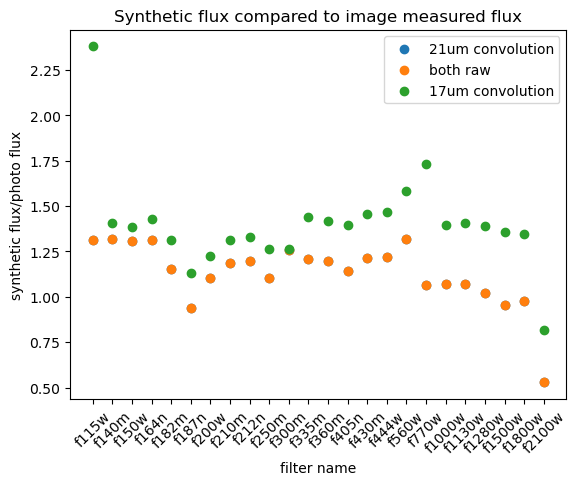

In [24]:
#homogenize_to_target_psf(image_files[6], 21e-6, output_file='location_0/f200w_image_convolved_to_21um.fits', location = locations[0], size = 5*u.arcsec)
#homogenize_to_target_psf(cut_files[6], 21e-6, output_file=f"Convolved_to_21um/{cut_files[6].split('/')[-1].split('_')[0]}_ifu_convolved.fits")
#test_convolve_image(image_files[6], 21e-6, 'F200W')
#test_convolve_image(cut_files[6], 21e-6, 'F200W')
#test_convolve_image(file_path, target_wavelength_m, native_filter, output_filepath=None)
'''
for i, file in enumerate(cut_files[::-1]):
    filter = file.split('/')[-1].split('_')[0]
    test_convolve_image(file, 21e-6, filter, output_filepath = f'Data_files/IFU_files/Convolved_to_21um/test_{filter}_IFU{i}_convolved_to_21um.fits')

for i, file in enumerate(image_files[::-1]):
    filter = extract_filter_name(file).upper()
    test_convolve_image(file, 21e-6, filter, output_filepath = f'Data_files/Image_files/Convolved_images/test_{filter}_img{i}_convolved_to_21um.fits')
'''
'''
conv_image_files = glob.glob('Data_files/Image_files/Convolved_images/test*.fits')
conv_ifu_files = glob.glob('Data_files/IFU_files/Convolved_to_21um/test*.fits')
radius = 0.75*u.arcsec
loc = locations[0]
conv_y_data = []
for file in filter_files:
    filter_name = extract_filter_name(file).upper()
    image_file = [img for img in image_files if extract_filter_name(img).upper() == filter_name][0]
    photo_flux = get_image_flux(image_file, loc, radius)
    filter_data = []
    with open(file, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)
            
    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
    filter_trans = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
    ifu_files = which_fits(file, raw_files)
    ifu_spectrum = stitch_spectra(ifu_files, loc, radius, anchor_idx=0, replace_negatives = 0)
    ifu_flux = get_Fnu_transmission(ifu_spectrum["intensity"], ifu_spectrum["wavelength"], filter_trans, filter_wl)
    conv_y_data.append(ifu_flux/photo_flux)
'''
x_axis = np.array([extract_filter_name(x) for x in filter_files])
conv_data = np.array([x_axis, conv_y_data])
#np.save(f'Data_files/misc_data/Updated_flux_calibration/location{l}_both_convolved_to17p1um.npy', conv_data)
#np.save(f'Data_files/misc_data/Updated_flux_calibration/location{l}_raw_files.npy', raw_data)
#np.save(f'Data_files/misc_data/Updated_flux_calibration/location0_21um_files.npy', conv_data)
raw_data = np.load('Data_files/misc_data/Updated_flux_calibration/location0_raw_files.npy')
grant_data = np.load('Data_files/misc_data/Updated_flux_calibration/location0_both_convolved_to17p1um.npy')
x = raw_data[0]
raw_y = [try_float(i) for i in raw_data[1]]
grant_y = [try_float(i) for i in grant_data[1]]
conv_y = [try_float(i) for i in conv_data[1]]

plt.scatter(x, conv_y, label = '21um convolution')
plt.scatter(x, raw_y, label = 'both raw')
plt.scatter(x, grant_y, label = '17um convolution')
#plt.ylim(0.8, 1.6)
plt.ylabel('synthetic flux/photo flux')
plt.xlabel('filter name')
plt.title('Synthetic flux compared to image measured flux')
plt.xticks(rotation=45)
plt.legend()
plt.show()
print()

In [4]:
rads = [0.2, 0.4, 0.6, 0.75, 1]
for l, loc in enumerate(locations):
    all_conv_image_files = glob.glob(f'Data_files/Image_files/Convolved_images/location_{l}/*')
    if l==2:
        raw_files = glob.glob(f'Data_files/IFU_files/raw_IFUs/location_1/*')
        conv_files = glob.glob(f'Data_files/IFU_files/Grant_files/location_1/*')
    else:
        raw_files = glob.glob(f'Data_files/IFU_files/raw_IFUs/location_{l}/*')
        conv_files = glob.glob(f'Data_files/IFU_files/Grant_files/location_{l}/*')
    print('Using files: ', raw_files)
    radius = 0.75*u.arcsec
    conv_y_data = []
    raw_y_data = []
    for file in filter_files:
        filter_name = extract_filter_name(file).upper()
        raw_image_file = [img for img in image_files if extract_filter_name(img).upper() == filter_name][0]
        raw_photo_flux = get_image_flux(raw_image_file, loc, radius)
        conv_image_file = [img for img in all_conv_image_files if extract_filter_name(img).upper() == filter_name][0]
        conv_photo_flux = get_image_flux(conv_image_file, loc, radius)
        filter_file = [flt for flt in filter_files if extract_filter_name(flt).upper() == filter_name][0]
        filter_data = []
        with open(filter_file, 'r') as f:
            header = f.readline().strip().split()
            for line in f:
                data_line = line.strip().split()
                filter_data.append(data_line)
                
        header, filter_T = filter_data[:2], np.array(filter_data[2:])
        filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
        filter_trans = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
        raw_ifu_files = which_fits(filter_file, raw_files)
        raw_spectrum = stitch_spectra(raw_ifu_files, loc, radius, anchor_idx=0, replace_negatives = 0)
        raw_ifu_flux = get_Fnu_transmission(raw_spectrum["intensity"], raw_spectrum["wavelength"], filter_trans, filter_wl)
        raw_y_data.append(raw_ifu_flux/raw_photo_flux)
        conv_ifu_files = which_fits(filter_file, conv_files)
        conv_spectrum = stitch_spectra(conv_ifu_files, loc, radius, anchor_idx=0, replace_negatives = 0)
        conv_ifu_flux = get_Fnu_transmission(conv_spectrum["intensity"], conv_spectrum["wavelength"], filter_trans, filter_wl)
        conv_y_data.append(conv_ifu_flux/conv_photo_flux)

    x_axis = np.array([extract_filter_name(x) for x in filter_files])
    raw_data = np.array([x_axis, raw_y_data])
    conv_data = np.array([x_axis, conv_y_data])
    np.save(f'Data_files/misc_data/Updated_flux_calibration/location{l}_both_convolved_to17p1um.npy', conv_data)
    np.save(f'Data_files/misc_data/Updated_flux_calibration/location{l}_raw_files.npy', raw_data)
    
    plt.scatter(x_axis, conv_y_data, label = 'both convolved')
    plt.scatter(x_axis, raw_y_data, label = 'both raw')
    plt.ylim(0.8, 1.6)
    plt.ylabel('synthetic flux/photo flux')
    plt.xlabel('filter name')
    plt.title('Synthetic flux compared to image measured flux')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

Using files:  ['Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g140m-f100lp_s3d.fits', 'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g395m-f290lp_s3d.fits', 'Data_files/IFU_files/raw_IFUs/location_0/jw03435-o004_t005_nirspec_g235m-f170lp_s3d.fits', 'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch1-shortmediumlong_s3d.fits', 'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch2-shortmediumlong_s3d.fits', 'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch4-shortmediumlong_s3d.fits', 'Data_files/IFU_files/raw_IFUs/location_0/Arm1_Level3_ch3-shortmediumlong_s3d.fits', 'Data_files/IFU_files/raw_IFUs/location_0/F115W_raw_0.fits', 'Data_files/IFU_files/raw_IFUs/location_0/F140M_raw_0.fits', 'Data_files/IFU_files/raw_IFUs/location_0/F150W_raw_0.fits', 'Data_files/IFU_files/raw_IFUs/location_0/F164N_raw_0.fits', 'Data_files/IFU_files/raw_IFUs/location_0/F182M_raw_0.fits', 'Data_files/IFU_files/raw_IFUs/location_0/F187N_raw_0.fits', 'Da

FileNotFoundError: [Errno 2] No such file or directory: 'D'

In [ ]:

    if show_normalized_fluxes:
        plt.style.use('seaborn-v0_8-paper')  #TJ just a random style for the plot
        
        plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12}) #TJ 
        # Now plot with sorted data
        plt.figure(figsize=(10, 6))
        if include_karin:
            plt.scatter([extract_filter_name(x) for x in filter_files], Karin_expected_flux/photo_flux, label='Karin convolution', s=100, marker='o', color='blue')
        plt.scatter([extract_filter_name(x) for x in filter_files[NIRSpec_indices]], IFU_expected_flux/photo_flux[NIRSpec_indices], label='raw IFU', s=100, marker='x', color='red')
        plt.scatter(extract_filter_name(filter_files[11]), IFU_335_expected/photo_flux[11], label='my convolution', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[12]), IFU_360_expected/photo_flux[12], label='', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[13]), IFU_405_expected/photo_flux[13], label='', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[14]), IFU_430_expected/photo_flux[14], label='', s=50, marker='x', color='black')
        plt.scatter(extract_filter_name(filter_files[15]), IFU_444_expected/photo_flux[15], label='', s=50, marker='x', color='black')

        plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, alpha=0.7)
        plt.xticks(rotation=45, ha='right')
        plt.tick_params(axis='y', which='both', labelsize=10)
        plt.legend()
        plt.xlabel('Filter Names')
        plt.ylabel('Filter Pass Through (MJy)')
        plt.title("FLux transmitted through filter compared to spectrum-derived expectations \nNormalized to Spectrum-derived values")
        plt.tight_layout()
        plt.show()
    if show_raw_fluxes:
        plt.style.use('seaborn-v0_8-paper')  #TJ just a random style for the plot
        
        plt.rcParams.update({'font.size': 12, 'axes.titlesize': 14, 'axes.labelsize': 12}) #TJ 
        # Now plot with sorted data
        plt.figure(figsize=(10, 6))
        if include_karin:
            plt.scatter([extract_filter_name(x) for x in filter_files], Karin_expected_flux, label='Karin', s=100, marker='o', color='blue')
        plt.scatter([extract_filter_name(x) for x in filter_files], photo_flux, label = 'image_extracted', s=100, marker = 'x', color = 'red')
        plt.scatter([extract_filter_name(x) for x in filter_files[NIRSpec_indices]], IFU_expected_flux, label='IFU-determined', s=50, marker='x', color='green')
        plt.scatter(extract_filter_name(filter_files[11]), IFU_335_expected, label='', s=50, marker='x', color='black')
        
        plt.xticks(rotation=45, ha='right')
        plt.tick_params(axis='y', which='both', labelsize=10)
        plt.legend()
        plt.xlabel('Filter Names')
        plt.ylabel('Filter Pass Through (MJy)')
        plt.title("FLux transmitted through filter compared to spectrum-derived expectations \nNormalized to Spectrum-derived values")
        plt.tight_layout()
        plt.show()


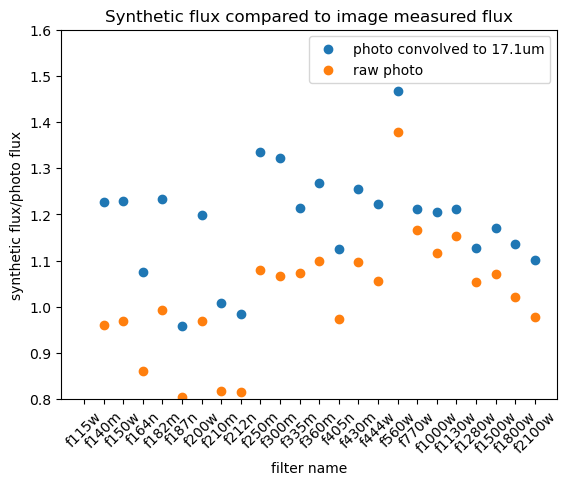

In [9]:
plt.scatter(x_axis, y_data, label = 'photo convolved to 17.1um')
plt.scatter(x_axis, raw_y_data, label = 'raw photo')
plt.ylim(0.8, 1.6)
plt.ylabel('synthetic flux/photo flux')
plt.xlabel('filter name')
plt.title('Synthetic flux compared to image measured flux')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [ ]:
saved_array = np.array(Karin_expected_flux)

# Save file
np.save('Data_files/misc_data/Karin_expected_flux.npy', saved_array)

In [ ]:
Thomas_values = np.array([IFU_335_expected, IFU_360_expected, IFU_405_expected, IFU_430_expected, IFU_444_expected])
np.save('Data_files/misc_data/Thomas_reduction_expected_fluxes', Thomas_values)

In [ ]:
hdul = fits.open(IFU_filepath) #TJ load file
data = hdul['SCI'].data*1e-20  #TJ convert flux density to mks units
header = hdul['SCI'].header #TJ load header
header

In [ ]:
for name in [extract_filter_name(x) for x in filter_files]:
    print(name.replace("f","F").replace("w","W").replace("m", "M").replace("n", "N"))

In [ ]:
array = [IFU_335_expected/photo_flux[11], IFU_360_expected/photo_flux[12], IFU_405_expected/photo_flux[13],IFU_430_expected/photo_flux[14],IFU_444_expected/photo_flux[15]]
np.std(array)

In [ ]:
def get_filter_wl_range(filter):
    '''Use the filter files to determine what wavelength range we need for each filter
    -------------
    
    Parameters
    -------------
    filter : type = str - string describing the filter name (case sensitive), for example "F335M"

    Returns
    -------------
    Path to newly convolved file as a string
    '''   
    filter_files = ['/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F115W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F140M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F150W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F164N.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F182M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F187N.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F200W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F210M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F212N.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F250M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F300M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F335M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F360M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F405N.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F430M.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F444W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F560W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F770W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F1000W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F1130W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F1280W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F1500W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F1800W.dat',
       '/d/crow1/tools/cigale/database_builder/filters/jwst/miri/F2100W.dat']
    filter_file = [filer_filepath for filer_filepath in filter_files if extract_filter_name(filer_filepath).upper() == filter][0]
    filter_data = []
    with open(filter_file, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)

    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
    return filter_wl[0]*u.m, filter_wl[-1]*u.m

In [ ]:
cube = SpectralCube.read('Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits', hdu='SCI')
cube_wl = cube.spectral_axis.to(u.m)
wl1, wl2 = get_filter_wl_range('F115W')
idx = np.where((cube_wl >= wl1) & (cube_wl <= wl2))[0]

In [ ]:
def test(integer):
    if integer > 3:
        return 6, None
    else:
        return 6, 3
x,y = test()

In [ ]:
convolved_cubes = glob.glob('Data_files/IFU_files/*convolved*')

In [ ]:
filter_names = ['F115W', 'F140M', 'F150W', 'F164N', 'F182M', 'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F300M', 'F335M', 'F360M', 'F405N', 
           'F430M', 'F444W', 'F560W', 'F770W', 'F1000W', 'F1130W', 'F1280W', 'F1500W', 'F1800W', 'F2100W'] 
for filter in filter_names:
    print("for filter ", filter)
    print(get_filter_wl_range(filter))

In [ ]:
x = np.load(f'Data_files/misc_data/flux_v_radius/F335M_radius_dependance.npy')
y = np.load('Data_files/misc_data/flux_v_radius/F335M_bright_source_radius_dependence.npy')
#plt.scatter(y[1], y[0])
plt.scatter(x[1], x[0])
filter_files

In [ ]:
filter_file = '/d/crow1/tools/cigale/database_builder/filters/jwst/nircam/F335M.dat'

filter_name = extract_filter_name(filter_file).upper()
original_IFUs = which_fits(filter_file, karin_SDuval_IFU_files)

#fluxes, radii = try_radii(original_IFUs, filter_name, test_loc, use_default=True)
#array = np.array([fluxes, radii])
#np.save(f'Data_files/misc_data/flux_v_radius/{filter_name}_raw_bright_source_radius_dependence.npy', array)

In [31]:
1*(u.deg**2).to(u.sr)

0.00030461741978670857